# Coding Tutorial 9 - Attention Mechanism

```
Course: CSCI 5922 Spring 2025, University of Colorado Boulder
TA: Everley Tseng
Email: Yu-Yun.Tseng@colorado.edu
* AI assistant is used in making this tutorial
```

## Overview

Sections:
- Multi-head attention layer
- Transformer block
- Build an attention model

Objectives:
- Learn how to use the built-in multi-head attention layer in PyTorch
- Learn the structure of a transformer block
- Learn how to build an attention model using embedding layers and transformer blocks
- Learn to leverage the NLP datasets on Hugging Face (`datasets`)
- Learn how to interpret the attention maps

In [ ]:
import torch
import torch.nn as nn

## Multi-Head Attention

Recall the attention mechanism learned in the lecture. A **Scalred Dot-Product Attention** layer performs the attention computation using the inputs, $Q$, $K$, and $V$, where the results after the softmax layer is what we call an **attention map**. The **Multi-Head Attention** structure is consist of multiple (i.e., $h$) attention heads.

<img src="https://aiml.com/wp-content/uploads/2023/09/Self-Attention-vs-Multi-headed-Attention.png" alt="Illustration of attention mechanism in the paper Attention Is All You Need." width="50%">

*Vaswani et al. Attention Is All You Need. NeurIPS 2017.*

### Multi-Head Attention Layer in PyTorch


In PyTorch, the implementation of the multi-head attention structure is in [`nn.MultiHeadAttention`](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html). Through the documentation, we can find that the layer returns both the layer output and the attention map (i.e., `attn_output_weights`), where the map is an averaged map in the $h$ heads:
```
multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
attn_output, attn_output_weights = multihead_attn(query, key, value)
```

Let's start with calling this layer and pass in some dummy values and observe the size of the tensors!

In [ ]:
# Define parameters
embed_dim = 64   # Embedding size
num_heads = 8    # Number of attention heads
seq_length = 10  # Sequence length
batch_size = 1   # Number of sequences

# Create the MultiheadAttention layer
multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)

# Create dummy input tensors (query, key, value)
x = torch.randn(batch_size, seq_length, embed_dim)  # (batch, seq_len, embed_dim)

# Apply self-attention (query = key = value)
attn_output, attn_weights = multihead_attn(x, x, x)

print("Attention Input Shape:", x.shape)  # (batch_size, seq_length, embed_dim)
print("Attention Output Shape:", attn_output.shape)  # (batch_size, seq_length, embed_dim)
print("Attention Weights Shape:", attn_weights.shape)  # (batch_size, seq_length, seq_length)

Attention Input Shape: torch.Size([1, 10, 64])
Attention Output Shape: torch.Size([1, 10, 64])
Attention Weights Shape: torch.Size([1, 10, 10])


For the each input, we perform **self-attention**, meaning it is passed into the layer as $Q$, $K$, and $V$. The shape of each output should be:

- Self-attention output: $\text{seq_length} \times \text{embed_dim}$  
  - Each element in the sequence has an **embedding of size** `embed_dim`.

- Attention map shape: $\text{seq_length} \times \text{seq_length}$  
  - This represents **self-attention values** from each query to itself.

**How Does the Shape Change?**

The change in shape occurs during **matrix multiplication of $Q$ and $K$**:
$\text{Attention Scores} = Q K^T$

Since $Q$ and $K$ both have a shape of $\text{seq_length} × \text{embed_dim}$, their matrix multiplication results in:
$(\text{seq_length} \times \text{embed_dim}) \cdot (\text{embed_dim} \times \text{seq_length}) = \text{seq_length} \times \text{seq_length}$

This produces the **attention map**, which encodes how much each token attends to every other token in the sequence.


## Transformer Block


Using multi-head attention layers, we are able to build self-attention transformer blocks like the gray box illustrated below.

<img src="https://miro.medium.com/v2/resize:fit:438/1*7sjcgd_nyODdLbZSxyxz_g.png" alt="Illustration of attention mechanism in the paper Attention Is All You Need." width="25%">

*Vaswani et al. Attention Is All You Need. NeurIPS 2017.*

This block includes a multi-head attention layer followed by norm and residual connection and a feed forward layer followed by norm and residual connection.

### Implement Transformer Block in PyTorch

Using the `nn.MultiHeadAttention` layer, let's now implement a self-attention block.

To prevent overfitting, we apply dropout layers after the multi-head attention layer and the feed forward layer. Don't forget to **save the attention map**. While this isn't necessary for the model forward and backward, we will be using this information later for visualization.

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout=0.1):
        super().__init__()

        # Multi-Head Self-Attention
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        # Two Layer Normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Feedforward Network (FFN)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim)
        )

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Multi-Head Self-Attention -> Residual & Norm
        attn_output, attn_weights = self.self_attn(x, x, x, attn_mask=mask)  # Get attention weights
        x = self.norm1(x + self.dropout(attn_output))

        # Feedforward -> Residual & Norm
        ff_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x, attn_weights  # Return both output and attention weights for visualization

Let's pass in dummy values again to see the tensor shapes. They should be the same as in a multi-head attention layer.

In [ ]:
# Define parameters
embed_dim = 64   # Embedding size
num_heads = 8    # Number of attention heads
seq_length = 10  # Sequence length
hidden_dim = 256 # Hidden state size
batch_size = 1   # Number of sequences

transformer_block = TransformerBlock(embed_dim=embed_dim, num_heads=num_heads, hidden_dim=hidden_dim)
x = torch.randn(batch_size, seq_length, embed_dim)
block_output, attn_weights = transformer_block(x)

print("Transformer Block Input Shape:", x.shape)  # (batch_size, seq_length, embed_dim)
print("Transformer Block Output Shape:", block_output.shape)  # (batch_size, seq_length, embed_dim)
print("Transformer Block Weights Shape:", attn_weights.shape)  # (batch_size, seq_length, seq_length)

Transformer Block Input Shape: torch.Size([1, 10, 64])
Transformer Block Output Shape: torch.Size([1, 10, 64])
Transformer Block Weights Shape: torch.Size([1, 10, 10])


## Attention Model

### Architecture

Using these Transformer blocks, let's build a classification model! When constructing the model, consider the following key components:

1. Embedding: Instead of using pretrained embeddings, we can train an embedding layer alongside the model. To create the embedding layer, use `nn.Embedding`, which acts as a lookup table with a shape of `(vocab_size, embed_dim)`.
  - Whether using pretrained embeddings or training from scratch, handling embeddings inside the model eliminates the need to preprocess the dataset into embeddings beforehand. This significantly reduces data preprocessing time and storage requirements.
2. Output Processing: The final Transformer block in our model produces an output of shape `(batch_size, seq_length, embed_dim)`. But how do we process this for classification?
  - In NLP classification tasks, we commonly use the hidden state of the `[CLS]` token (the first token in the sequence) as a summary representation of the input text.
  - Extract the hidden state corresponding to `[CLS]` from the final attention layer and pass it through a fully connected layer to obtain the classification output.
3. Saving Attention Maps: If you plan to visualize attention weights, remember to return attention maps in `forward`. In this case, since we will be visualizing attention, ensure the maps are stored in `attention_maps`.


In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, hidden_dim, num_layers, max_seq_len, num_classes=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = nn.Embedding(max_seq_len, embed_dim)

        # Transformer layers
        self.transformer_layers = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, hidden_dim, dropout) for _ in range(num_layers)
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(embed_dim, num_classes)  # Output layer (for classification)

    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        positions = torch.arange(0, seq_len).expand(batch_size, seq_len).to(input_ids.device)

        x = self.embedding(input_ids) + self.pos_embedding(positions)

        attention_maps = [] # store maps here
        for layer in self.transformer_layers:
            x, attn_map = layer(x)
            attention_maps.append(attn_map)

        x = x[:, 0, :]  # Take first token representation (CLS token)
        x = self.dropout(x)
        logits = self.fc_out(x)  # Binary classification logits (before softmax)

        return logits, attention_maps

### IMDB Dataset



#### Hugging Face Datasets



In Coding Tutorial 8, we introduced the Hugging Face library, which is widely known for its pretrained models in `transformers` and its diverse collection of datasets in `datasets`. In this tutorial, we will load an NLP dataset from the Hugging Face library to train our model.

The datasets module in Hugging Face offers a vast collection of NLP datasets. To explore available datasets, visit the [datasets tab](https://huggingface.co/datasets?modality=modality:text&sort=trending), where you can filter by categories such as "text" or "classification" to find relevant datasets.




In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 29.7 MB/s eta 0:00:00


We'll be using the [IMDB dataset](https://huggingface.co/datasets/stanfordnlp/imdb) for sentiment classification. This dataset consists of movie reviews labeled as either positive or negative.

To load a dataset from Hugging Face, copy the dataset name from the webpage (e.g., `stanfordnlp/imdb`) and use `datasets.load_dataset` to import it into your script.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("stanfordnlp/imdb") # Load IMDB dataset

print('Train size:', len(dataset['train']))
print('Test size:', len(dataset['test']))
print('Text data:', dataset['train'][0]['text'])
print('Label:', dataset['train'][0]['label'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train size: 25000
Test size: 25000
Text data: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex 

### Tokenization



In this example, we apply the tokenization method used in **Coding Tutorial 8**: [`bert-base-uncased`](https://huggingface.co/google-bert/bert-base-uncased).

This method tokenizes words from text data and adds special tokens: `[CLS]` at the beginning to indicate the start of a sequence and `[SEP]` at the end to mark its termination. It is a common practice to standardize the length of all input samples. By setting a maximum sequence length (`max_length=max_seq_len`), we can ensure that:
- Longer sequences are truncated (`truncation=True`)
- Shorter sequences are padded with `[SEP] `(`padding='max_length'`)


In [ ]:
from transformers import AutoTokenizer

# Create tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize text
max_seq_len = 256
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=max_seq_len)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
print('Train size:', len(tokenized_datasets['train']))
print('Test size:', len(tokenized_datasets['test']))
print('Text data:', tokenized_datasets['train'][0]['input_ids'])
print('Label:', tokenized_datasets['train'][0]['label'])

Train size: 25000
Test size: 25000
Text data: [101, 1045, 12524, 1045, 2572, 8025, 1011, 3756, 2013, 2026, 2678, 3573, 2138, 1997, 2035, 1996, 6704, 2008, 5129, 2009, 2043, 2009, 2001, 2034, 2207, 1999, 3476, 1012, 1045, 2036, 2657, 2008, 2012, 2034, 2009, 2001, 8243, 2011, 1057, 1012, 1055, 1012, 8205, 2065, 2009, 2412, 2699, 2000, 4607, 2023, 2406, 1010, 3568, 2108, 1037, 5470, 1997, 3152, 2641, 1000, 6801, 1000, 1045, 2428, 2018, 2000, 2156, 2023, 2005, 2870, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 5436, 2003, 8857, 2105, 1037, 2402, 4467, 3689, 3076, 2315, 14229, 2040, 4122, 2000, 4553, 2673, 2016, 2064, 2055, 2166, 1012, 1999, 3327, 2016, 4122, 2000, 3579, 2014, 3086, 2015, 2000, 2437, 2070, 4066, 1997, 4516, 2006, 2054, 1996, 2779, 25430, 14728, 2245, 2055, 3056, 2576, 3314, 2107, 2004, 1996, 5148, 2162, 1998, 2679, 3314, 1999, 1996, 2142, 2163, 1012, 1999, 2090, 4851, 8801, 1998, 6623, 7939, 4697, 3619, 1997, 8947, 2055, 2037, 10740, 2006, 4331, 1010, 2016, 2

To easily pass data into `DataLoader`, we can create our own dataset by inheriting the `Dataset` class in PyTorch. In this class, define:
- The size of the dataset in `__len__`
- The unpacked data through and index `ind`, return x (i.e., input_ids) and y (i.e., label) in `__getitem__`

In [ ]:
from torch.utils.data import DataLoader, Dataset

class IMDBDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        input_ids = torch.tensor(item["input_ids"])
        label = torch.tensor(item["label"])
        return input_ids, label

# Create dataset splits
train_dataset = IMDBDataset(tokenized_datasets['train'])
test_dataset = IMDBDataset(tokenized_datasets['test'])

# Set up dataloader for batches
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

### Model Training

Now, we are ready to train the model! Let's create a model with one transformer block (i.e., `num_layers = 1`).

In [ ]:
import torch.optim as optim

# Define model hyperparameters
vocab_size = tokenizer.vocab_size # Get vocab size from tokenizer
embed_dim = 128
num_heads = 8
hidden_dim = 256
num_layers = 1
num_classes = 2
learning_rate = 2e-5
num_epochs = 10

# Initialize
model = TransformerClassifier(vocab_size, embed_dim, num_heads, hidden_dim,
                              num_layers, max_seq_len, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for input_ids, labels in train_dataloader:
        input_ids, labels = input_ids.to(device), labels.to(device)
        optimizer.zero_grad()
        logits, _ = model(input_ids)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.6f}")

Epoch 1 - Loss: 0.695585
Epoch 2 - Loss: 0.664811
Epoch 3 - Loss: 0.609568
Epoch 4 - Loss: 0.578804
Epoch 5 - Loss: 0.560909
Epoch 6 - Loss: 0.542837
Epoch 7 - Loss: 0.519650
Epoch 8 - Loss: 0.492495
Epoch 9 - Loss: 0.476067
Epoch 10 - Loss: 0.457867


### Evaluation

Evaluate the model on test set. The function [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) is similar to `torchmetrics.Accuracy`. As `sklearn` is preinstalled on Colab, we will use this function to calculate accuracy here.

In [ ]:
from sklearn.metrics import accuracy_score

model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for input_ids, labels in test_dataloader:
        input_ids, labels = input_ids.to(device), labels.to(device)
        logits, _ = model(input_ids)
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7635


### Attention Maps

To visualize attention, plot the attention values from the multi-head attention layer(s).

Recall that the attention map has dimensions of `seq_length` by `seq_length`, where `seq_length` is set to 256 in our model. Let’s visualize the attention map for `[CLS]` (i.e., the first token) to examine how it attends to each token in the sentence. For simplicity, we will ignore padding tokens at the end of the sequence.

In [ ]:
def attention_map(input_text):
    print('\nInput text: {}'.format(sample_text))

    # Tokenize the input
    tokens = tokenizer(input_text, padding='max_length', truncation=True,
                       max_length=max_seq_len, return_tensors="pt")
    input_ids = tokens['input_ids'].to(device)

    # Prepare token cound and words for visualization
    valid_token_count = (tokens['input_ids'] != tokenizer.pad_token_id).sum().item() - 1
    words = tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).tolist())

    # Predict: get prediction and attention maps
    with torch.no_grad():
        logits, attention_maps = model(input_ids)
        preds = torch.argmax(logits, dim=1)
        prediction = 'Positive' if preds.cpu().numpy()[0] == 1 else 'Negative'
        print('Prediction: {}'.format(prediction))
        attn_weights = [m.squeeze(0).detach().cpu().numpy() for m in attention_maps]

    # Plot attention heatmap for each layer
    for l in range(num_layers):
        plt.figure(figsize=(12, 0.5))
        visualize_map = attn_weights[l][:1, 1:valid_token_count]
        sns.heatmap(visualize_map, xticklabels=words[1:valid_token_count], yticklabels=words[:1],
                    cmap="Blues", annot=True)
        plt.title(f'Layer {l+1}')
        plt.show()


Input text: The movie was absolutely amazing and I loved it.
Prediction: Positive


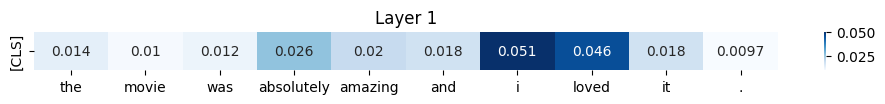


Input text: Terrible movie...one of the worst
Prediction: Negative


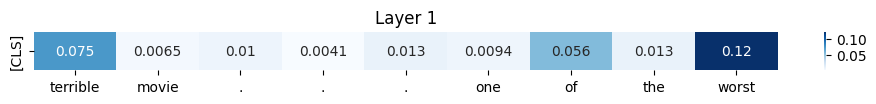


Input text: Excellent cast!! Brad Pitt is gorgeous!!
Prediction: Positive


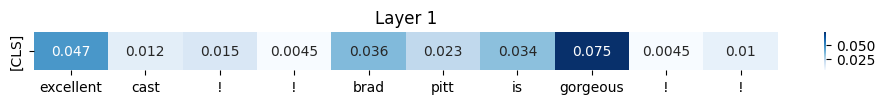


Input text: Bad bad bad bad bad movie 
Prediction: Negative


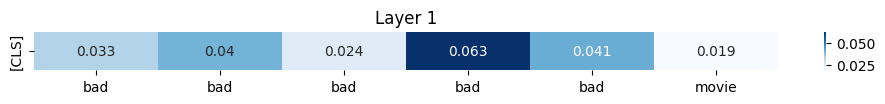

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sample_text = 'The movie was absolutely amazing and I loved it.'
attention_map(sample_text)

sample_text = 'Terrible movie...one of the worst'
attention_map(sample_text)

sample_text = 'Excellent cast!! Brad Pitt is gorgeous!!'
attention_map(sample_text)

sample_text = 'Bad bad bad bad bad movie '
attention_map(sample_text)

We can see that the `[CLS]` token attends to the words in the sentence that can help determine the tone. For instance, "loved", "terrible", "worst", excellent", "gorgeous", and "bad".

## Review

You might notice a significant difference in computation time when using a CPU versus a GPU. The attention mechanism is highly optimized for parallel processing on GPUs, making it much more efficient for NLP tasks compared to recurrent structures.

By visualizing attention maps, we can gain insights into the model's internal workings, which is why attention-based architectures are often considered a step toward explainable AI. We encourage you to experiment with training a three-layer model (i.e., `num_layers=3`) and observe the resulting attention maps.

For any questions and discussions regarding this tutorial, attend [TA office hours](https://docs.google.com/spreadsheets/d/1fzfTJpEF7RaUYRA_NGa3DkiazdQXVj7QNBbp6DrEZ3I/edit?usp=sharing) or create a post on [Piazza](https://piazza.com/colorado/spring2025/csci5922/home) :) See you in the next tutorial!

\- Everley